# Spleen Segmentation Exercise

In this exercise, we will implement Spleen segmentation using the Medical Decathalon dataset. We'll follow these general steps:  

1. Transforms for dictionary format data.
2. Load Nifti image with metadata.
3. Add channel dim to the data if no channel dimension.
4. Scale medical image intensity with expected range.
5. Crop out a batch of balanced images based on positive / negative label ratio.
6. Cache IO and transforms to accelerate training and validation.
7. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
8. Sliding window inference method.
9. Deterministic training for reproducibility.

Optionally replace the training loop with the Ignite-derived engine classes.

First, we install and import MONAI plug other dependencies.

In [41]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.


In [51]:
!pip install -q "monai-weekly[einops]"

In [1]:
!pip list

Package                            Version
---------------------------------- -------------------
aiobotocore                        1.3.0
aiohttp                            3.7.4.post0
aioitertools                       0.7.1
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-project                   0.9.1
anyio                              2.1.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.7.3
astropy                            4.1
async-generator                    1.10
async-timeout                      3.0.1
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.5
autovizwidget                      0.19.1
awscli                             1.20.43
Babel                              2.9.0
backcall                       

In [2]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

MONAI version: 0.7.dev2138
Numpy version: 1.19.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfc42f02d3bbbc1bfa36abbc71df8a6ca863bd76

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.16.2
Pillow version: 8.3.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 3.13.1
TorchVision version: 0.8.2
tqdm version: 4.62.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.1.5
einops version: 0.3.2
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
import glob
import os

root_dir="."
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)
    
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

set_determinism(seed=0)

In [4]:
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    Activations,
    AsDiscrete,
    EnsureType,
    LoadImaged,
    AddChanneld,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    EnsureTyped
)
from monai.data.image_reader import NibabelReader

# LoadImage seems like it can't detect the Reader
train_transforms = Compose(
    [
#         LoadImage(image_only=True),
#         LoadImage(),
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         randomly crop out patch samples from big
#         image based on pos / neg ratio
#         the image centers of negative samples
#         must be in valid image area
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        EnsureTyped(keys=["image", "label"]),
#         AddChannel(),
#         ScaleIntensity(),
# #         RandRotate(range_x = 30, prob = 0.3, keep_size=True),
# #         RandFlip(spatial_axis=0, prob = 0.3),
# #         RandZoom(min_zoom = 0.9, max_zoom=1.1, prob = 0.3),
#         ToTensor()
    ]
)

val_transforms = Compose(
    [
#         LoadImage(image_only=True),
#         LoadImage(),
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        EnsureTyped(keys=["image", "label"]),
#         AddChannel(),
#         ScaleIntensity(),
#         ToTensor()
    ]
)

In [5]:
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandCropByPosNegLabeld,
    EnsureTyped,
#     ToDeviced
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
#         ToDeviced(keys=["image", "label"], device="cuda:0"),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [6]:
from monai.data import CacheDataset, DataLoader

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=10)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=10)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=10)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10) # batch size 4 seems to cause an error

Loading dataset: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


In [14]:
from monai.networks.nets import UNet, UNETR
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

device = torch.device("cuda:0")
# device = torch.device("cpu")
# model = UNet(
#     dimensions=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2,2,2,2),
#     num_res_units=2,
#     norm=Norm.BATCH
# ).to(device)  # TODO

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)  # TODO
optimizer = torch.optim.Adam(model.parameters(), 1e-4)  # TODO
dice_metric = DiceMetric(include_background=False, reduction="mean")  # TODO
scaler = torch.cuda.amp.GradScaler()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.76 GiB total capacity; 12.95 GiB already allocated; 10.75 MiB free; 13.10 GiB reserved in total by PyTorch)

In [11]:
!nvidia-smi
# set_determinism(seed=0)

Fri Sep 24 16:49:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |   1671MiB / 15109MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
from monai.data.utils import decollate_batch
from monai.transforms import EnsureType, AsDiscrete
from monai.inferers import sliding_window_inference
import time

start = time.time()


amp = True
max_epochs = 5
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        if amp and scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
#         outputs = model(inputs)
#         loss = loss_function(outputs, labels)
#         loss.backward()
#         optimizer.step()
        epoch_loss += loss.item()
        print(
#             f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                if amp:
                    with torch.cuda.amp.autocast():
                        val_outputs = sliding_window_inference(
                            val_inputs, roi_size, sw_batch_size, model
                        )
                else:
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model
                    )
#                 val_outputs = sliding_window_inference(
#                     val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

print("Total Elapsed Time: ")
end = time.time()
print(end - start)

----------
epoch 1/5


OSError: [Errno 12] Cannot allocate memory

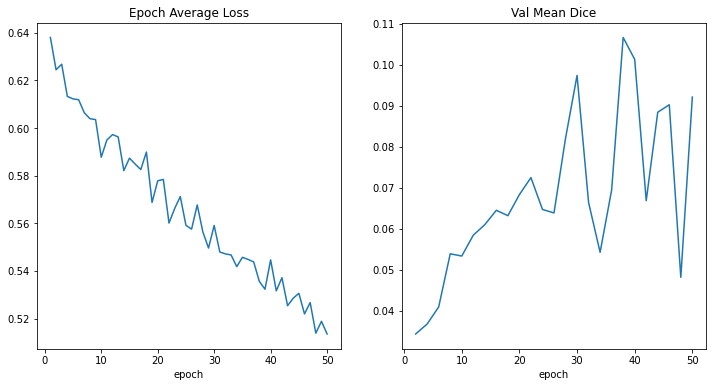

In [28]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [34]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_summary(0, abbreviated=True))

Tesla T4
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  504355 KB |    6137 MB |    9554 GB |    9554 GB |
|---------------------------------------------------------------------------|
| Active memory         |  504355 KB |    6137 MB |    9554 GB |    9554 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    6996 MB |    6996 MB |    6996 MB |       0 B  |
|------------------------------------------------------

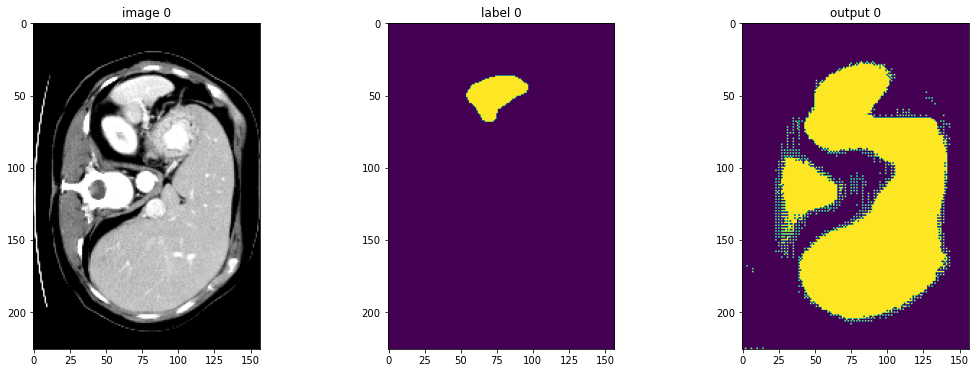

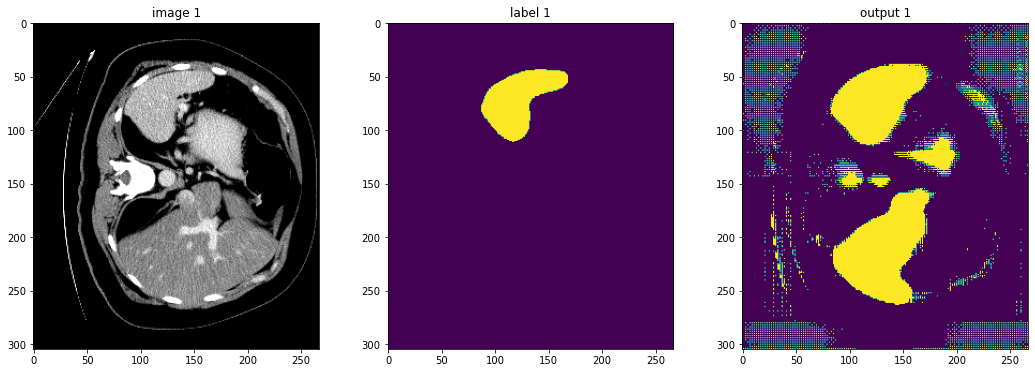

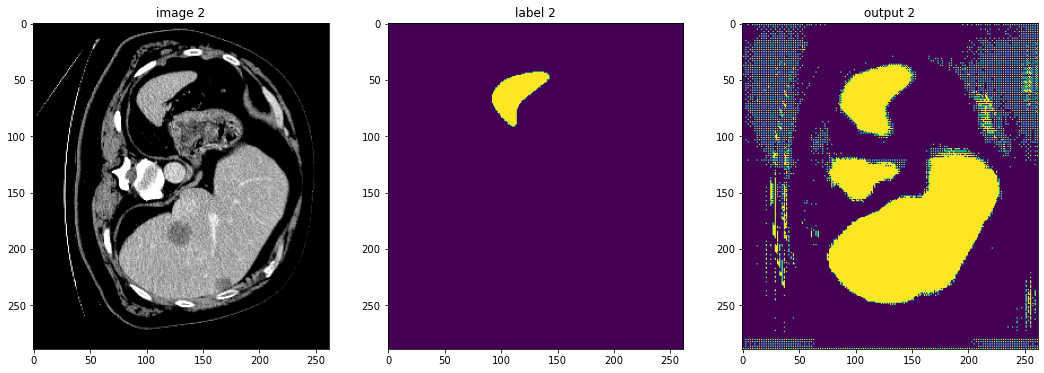

In [29]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break